Generate a basket of stocks and build different portfolios using PCA.
Find optimal portfolio by maximizing Sharpe ratio

In [2]:
# import relevant libraries

import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
from pandas_datareader import data as pdr # to import Stooq source
import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


In [6]:
# Import the dataset and save it as a DataFrame

tickers = ['AAPL', 'AMGN', 'AXP', 'BAC', 'CVX', 'JPM', 'MSFT', 'NVDA', 'WMT']

# determine time interval
yesterday = datetime.date.today() - datetime.timedelta(1)
start_date = datetime.datetime(2023, 1, 1)
end_date = yesterday

dict_tickers = {}
for t in tickers:
    df = pdr.DataReader(t, 'stooq', start_date, end_date) # pulls daily OHLCV
    df = df.sort_index() # from newest to oldest
    df['Adj Close'] = df['Close']
    dict_tickers[t] = df['Adj Close'] # use just one field for this notebook

# data = pd.concat(dict_tickers, axis=1) # same as line below for this purpose
data = pd.DataFrame(dict_tickers) # shape of the DataFrame is (T, m), T is the number of days, m = num_tickers x num_fields
data.tail()

,AAPL,AMGN,AXP,BAC,CVX,JPM,MSFT,NVDA,WMT
Date,,,,,,,,,
2025-08-29,232.14,287.71,331.28,50.74,160.60,301.42,506.69,174.18,96.98
2025-09-02,229.72,286.92,331.18,50.42,161.83,299.70,505.12,170.78,97.85
2025-09-03,238.47,283.85,323.71,50.06,158.06,299.51,505.35,170.62,99.44
2025-09-04,239.78,280.10,330.65,50.62,157.69,303.82,507.97,171.66,100.93
2025-09-05,239.69,283.64,326.22,49.77,153.66,294.38,495.00,167.02,100.51


In [9]:
# Preprocess: Handling nulls, removing outliers

def cleansing(data: pd.DataFrame):
    missing_fractions = data.isnull().mean().sort_values(ascending=False)
    drop_list = sorted(list(missing_fractions[missing_fractions > 0.3].index))
    data.drop(labels=drop_list, axis=1, inplace=True)

    data = data.ffill() # fill missing values with the last available data (for weekend or holidays)

    # drop rows containing missing values
    data = data.dropna(axis=0)

    return data

data = cleansing(data)
data.shape

(671, 9)

In [10]:
# Preprocess: Remove outliers beyond 3 standard deviations

def remove_outliers(data: pd.DataFrame):
    
    data_returns = data.pct_change() # fractional change from previous row
    data_returns[data_returns.apply(lambda x: (np.abs(x - x.mean()) < 3*x.std())).all(1)] # enforce the check across all columns

    return data_returns

data = remove_outliers(data)
data.shape

(671, 9)

In [13]:
# Preprocess: standardize to 0 mean and 1 variance

# Rescale
scaler = StandardScaler()
rescaled_data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns,
                             index=data.index)

# Drop rows with missing values
data.dropna(how='any', inplace=True)
rescaled_data.dropna(how='any', inplace=True)

rescaled_data.shape

(670, 9)

In [14]:
# Define train set and test set
percentage = 0.8
train_size = int(len(rescaled_data) * percentage)
X_train = rescaled_data[:train_size]
X_test = rescaled_data[train_size:]

X_train_raw = data[:train_size]
X_test_raw = data[train_size:]


In [15]:
# Apply PCA and take components

pca = PCA()
pca.fit(X_train)

pca_components = pca.components_
pca_components.shape

(9, 9)

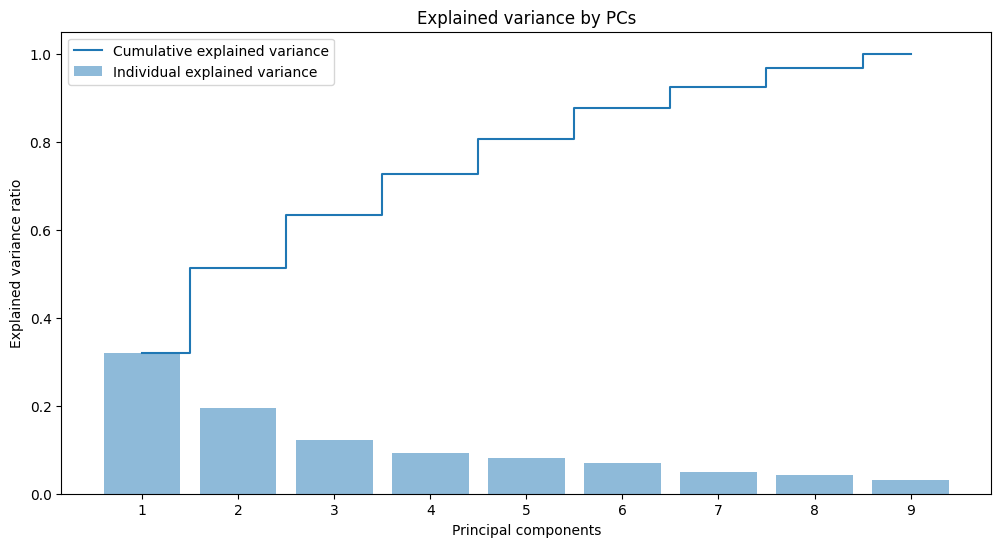

In [22]:
# Plot explained variance ratio

def plot_explained_variance_ratio(pca):
    explained_var_ratio = pca.explained_variance_ratio_
    num_expl_var_ratio = len(explained_var_ratio)
    cumsum_expl_var_retio = np.cumsum(explained_var_ratio)

    plt.figure(figsize=(12,6))

    plt.bar(range(1, num_expl_var_ratio+1), explained_var_ratio, alpha=0.5, align='center',
            label = 'Individual explained variance')
    plt.step(range(1, num_expl_var_ratio+1), cumsum_expl_var_retio, where='mid',
             label='Cumulative explained variance')
    
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.xticks(range(1, num_expl_var_ratio+1))
    plt.legend(loc='best')
    plt.title('Explained variance by PCs')

    plt.show()

plot_explained_variance_ratio(pca)

In [23]:
# Create portfolios using principal components

def create_portfolios(pca):
    
    weights = pd.DataFrame()

    for i in range(len(pca.components_)):
        weights['weights_'.format(i)] = pca.components_[i] / np.sum(pca.components_[i])

    weights = weights.values.T
    return weights

portfolios = create_portfolios(pca)

In [28]:
# Define Sharpe ratio for optimization

def sharpe_ratio(ts_returns, num_of_trading_days = 252):

    num_years = ts_returns.shape[0] / num_of_trading_days

    # compute average returns
    annualized_return = np.power(np.prod(1+ts_returns), (1/num_years)) - 1
    annualized_vol = ts_returns.std() * np.sqrt(num_of_trading_days)
    annualized_sharpe = annualized_return / annualized_vol

    return annualized_return, annualized_vol, annualized_sharpe

Portfolio #6 with the highest Sharpe. Return = 300, vol = 100, Sharpe = 300


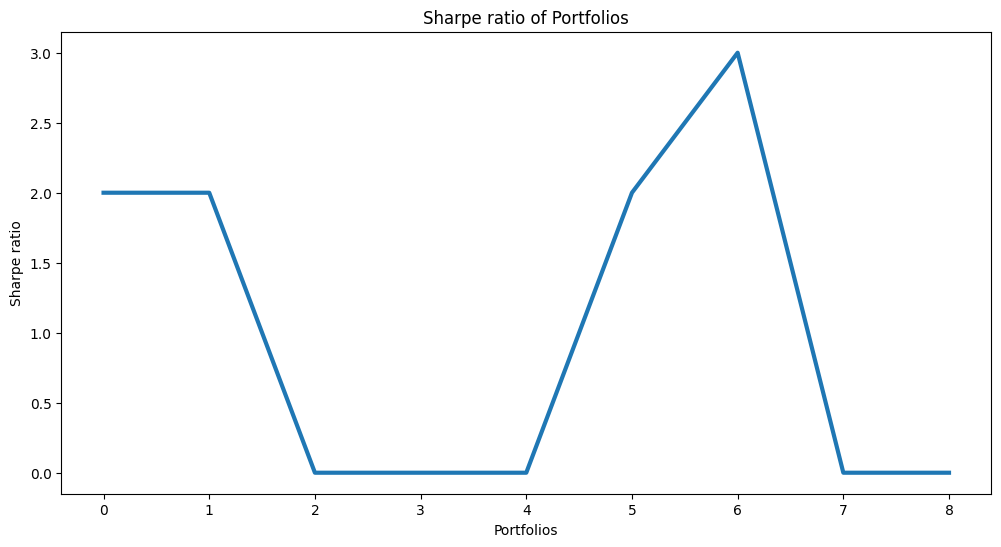

(6,
    Return  Vol  Sharpe
 6       3    1       3
 0       0    0       2
 1       2    1       2
 5       3    1       2
 2       0    0       0
 3       0    3       0
 4       0    0       0
 7       0    4       0
 8      -1    8       0)

In [33]:
# Optimize the portfolio

def plot_sharpe_metric(sharpe_metric):

    fig, ax = plt.subplots()
    fig.set_size_inches(12, 6)
    ax.plot(sharpe_metric, linewidth=3)
    ax.set_title('Sharpe ratio of Portfolios')
    ax.set_ylabel('Sharpe ratio')
    ax.set_xlabel('Portfolios')

    plt.show()

def optimizePortfolio(rescaled_data, X_train_raw, pca):

    num_portfolios = len(pca.components_)

    annualized_return = np.array([0] * num_portfolios)
    annualized_vol = np.array([0] * num_portfolios)
    sharpe_metric = np.array([0] * num_portfolios)

    stock_tickers = rescaled_data.columns.values
    num_tickers = len(stock_tickers)
    pcs = pca.components_

    for i in range(num_portfolios):

        pc_weight = pcs[i] / np.sum(pcs[i])
        portfolio = pd.DataFrame(data = {'weights': pc_weight.squeeze()*100},
                                 index = stock_tickers)
        portfolio_returns = np.dot(X_train_raw.loc[:, portfolio.index], pc_weight)

        ret, vol, sharpe = sharpe_ratio(portfolio_returns)
        annualized_return[i] = ret
        annualized_vol[i] = vol
        sharpe_metric[i] = sharpe

    highest_sharpe = np.argmax(sharpe_metric)

    print(f"Portfolio #{highest_sharpe} with the highest Sharpe. Return = {annualized_return[highest_sharpe]*100}, vol = {annualized_vol[highest_sharpe]*100}, Sharpe = {sharpe_metric[highest_sharpe]*100}")

    results = pd.DataFrame(data={'Return': annualized_return, 'Vol': annualized_vol, 'Sharpe': sharpe_metric})
    results.dropna(inplace=True)
    results.sort_values(by=['Sharpe'], ascending=False, inplace=True)

    plot_sharpe_metric(sharpe_metric)

    return highest_sharpe, results

optimizePortfolio(rescaled_data, X_train_raw, pca)


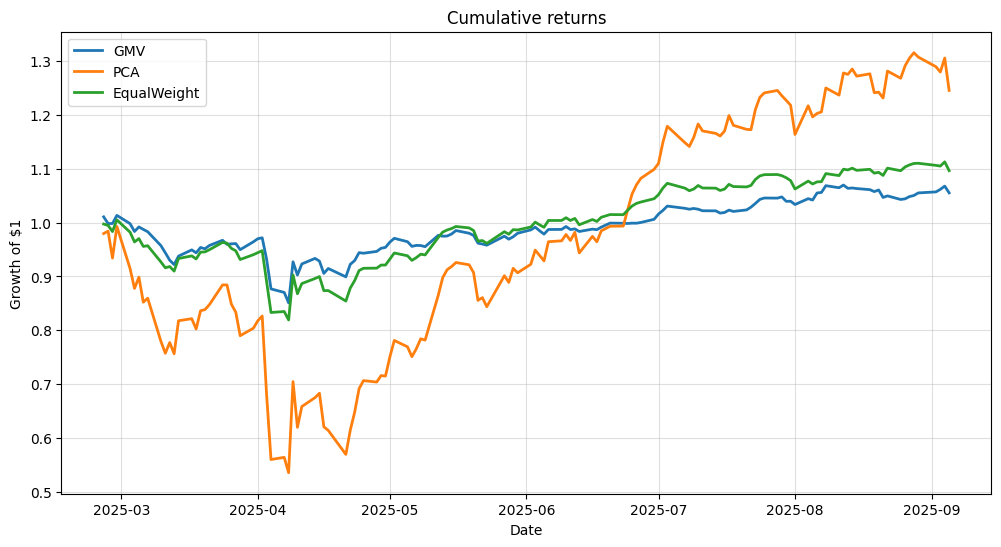

In [41]:
# Testing: define Global minimum variance (GMV) for comparison

def min_var_portfolio(returns):

    covariance_mat = returns.cov().to_numpy()
    n = covariance_mat.shape[0]

    inv_cov_mat = np.linalg.inv(covariance_mat)

    w_star = np.sum(inv_cov_mat, axis=1)
    w_star /= np.sum(inv_cov_mat)

    return pd.Series(w_star, index=returns.columns)

# Test against GMV and Equal Weight Index (EWI)

def backtest(pca_comp, stock_tickers, X_train_raw):

    optimized_portfolio = pd.DataFrame(data ={'weights': pca_comp.squeeze()}, index = stock_tickers)
    optimized_portfolio.sort_values(by=['weights'], ascending=False, inplace=True)    

    optimized_portfolio_returns = np.dot(X_test_raw.loc[:, optimized_portfolio.index], pca_comp)
    optimized_portfolio_returns = pd.Series(optimized_portfolio_returns.squeeze(), index=X_test_raw.index)
    returns, vol, sharpe = sharpe_ratio(optimized_portfolio_returns)  

    # EWI
    equal_weight_return=(X_test_raw * (1/len(pca.components_))).sum(axis=1)

    # GMV
    min_weight = min_var_portfolio(X_train_raw)
    GMV_return = (X_test_raw @ min_weight)


    df_plot = pd.DataFrame({
        'GMV': GMV_return.squeeze(),
        'PCA': optimized_portfolio_returns.squeeze(),
        'EqualWeight': equal_weight_return.squeeze()
        })
        
    cumulative = (1 + df_plot).cumprod()
    plt.figure(figsize=(12,6))
    for col in cumulative.columns:
        plt.plot(cumulative.index, cumulative[col], label=col, linewidth=2)
    plt.ylabel("Growth of $1")
    plt.xlabel("Date")
    plt.legend()
    plt.title('Cumulative returns')
    plt.grid(True, alpha=0.4)
    plt.show()

    return optimized_portfolio_returns, equal_weight_return, GMV_return

optimized_portfolio_returns, equal_weight_return, GMV_return = backtest(pca.components_[0], tickers, X_train_raw)
